In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive/')

# ディレクトリの移動
%cd /content/drive/My Drive/colony

# ディレクトリ内のデータの確認
%ls

Mounted at /content/drive/
/content/drive/My Drive/colony
colony_class_index.json  colony_mobilenet_v3_large.ipynb  model/
colony_data/             colony_test.ipynb


デバイス：cpu
Epoch: 1 / 50
--------------------------
train Loss: 4.0744 Accuracy: 0.3737
val Loss: 5.5027 Accuracy: 0.0000
Epoch: 2 / 50
--------------------------
train Loss: 0.6484 Accuracy: 0.7677
val Loss: 3.6042 Accuracy: 0.1212
Epoch: 3 / 50
--------------------------
train Loss: 0.3488 Accuracy: 0.8182
val Loss: 2.5822 Accuracy: 0.1818
Epoch: 4 / 50
--------------------------
train Loss: 0.4446 Accuracy: 0.8182
val Loss: 1.6927 Accuracy: 0.4242
Epoch: 5 / 50
--------------------------
train Loss: 0.2636 Accuracy: 0.8990
val Loss: 1.2123 Accuracy: 0.5758
Epoch: 6 / 50
--------------------------
train Loss: 0.3732 Accuracy: 0.8384
val Loss: 0.7874 Accuracy: 0.8182
Epoch: 7 / 50
--------------------------
train Loss: 0.5020 Accuracy: 0.8081
val Loss: 0.6805 Accuracy: 0.9394
Epoch: 8 / 50
--------------------------
train Loss: 0.2596 Accuracy: 0.8990
val Loss: 0.5081 Accuracy: 0.8788
Epoch: 9 / 50
--------------------------
train Loss: 0.2671 Accuracy: 0.8990
val Loss: 0.4203 Accuracy:

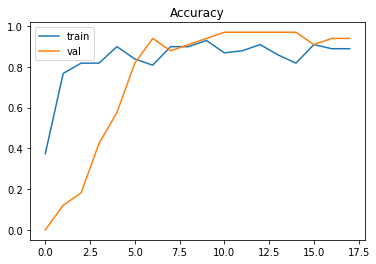

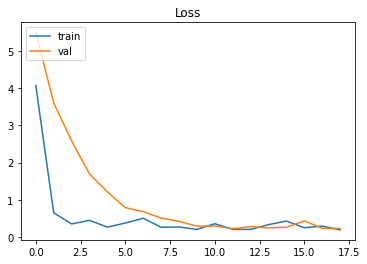

In [4]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch import nn, optim

from collections import defaultdict

'''
定数の指定
'''

# リサイズする画像サイズ
photo_size = 300

# バッチサイズ
batch_size = 8

# クラス数の定義
num_classes = 2

# 学習率
lr = 0.0001

# 学習済み
pretrained = True

# エポック数
epochs = 50

# 保存先のパス
save_path = '/content/drive/My Drive/colony/model/'

# 学習に使用する機器(device)の設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'デバイス：{device}')

'''
前処理
'''

# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.Resize(photo_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        # transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        transforms.Resize(photo_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

# ImageFolderによるデータセットの作成
train_dataset = datasets.ImageFolder("./colony_data/train", transform=transform['train'])
val_dataset = datasets.ImageFolder("./colony_data/val", transform=transform['val'])

# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
}

'''
学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

'''
モデルの定義
'''

model = models.mobilenet_v3_large(pretrained=pretrained)
fc_in_features = model.classifier[3].in_features # 最終レイヤー関数の次元数
model.fc = nn.Linear(fc_in_features, num_classes) # 最終レイヤー関数の付け替え

# モデルをGPUに送る
model.to(device)

'''
学習
'''

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=5, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

history = defaultdict(list)

# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            running_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    running_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')

            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'{save_path}{epoch+1}_logloss_{epoch_loss:.4f}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
            
        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break    

    # 正解率の推移をプロット
    plt.plot(history['train_accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # ロスの推移をプロット
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

'''
モデルの学習と推論の実行
'''

train_model(model, epochs, criterion, optimizer)